# Membangun MLP (Multi-Layer Perceptron) dengan JAX native

Notebook ini mendemonstrasikan cara membangun jaringan saraf tiruan dari nol menggunakan JAX murni, tanpa menggunakan framework tambahan.
Di sini kita mengelola parameter secara manual sebagai **Pytrees** dan mendefinisikan logika forward secara fungsional. 
Ini memberikan kontrol penuh atas alur eksekusi dan memori.

## 1. Persiapan Lingkungan & Import
Langkah pertama adalah menyiapkan library inti:
* `jax`: Library utama untuk komputasi fungsional dan diferensiasi otomatis.
* `jax.numpy (jnp)`: Implementasi NumPy di JAX yang berjalan di atas XLA (Accelerator-aware).
* `plot_lib`: Library utilitas lokal untuk visualisasi boundary keputusan.

In [ ]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import jax
import jax.numpy as jnp
import math

import plot_lib as pl
import importlib
importlib.reload(pl)


pl.set_default()

## 2. Generasi Data Sintetis (Spiral Dataset)
Kita membuat dataset spiral dengan 3 kelas. Dataset ini dipilih karena bersifat **non-linearly separable**, artinya tidak bisa dipisahkan hanya dengan garis lurus. Ini adalah tantangan yang tepat untuk menguji kemampuan MLP dalam mempelajari representasi non-linear.

### Penjelasan Detail Logika Matematika:
Untuk menghasilkan dataset spiral, kita menggunakan konsep **koordinat polar** $(r, \theta)$ yang kemudian dikonversi ke **koordinat Kartesius** $(x, y)$:

1.  **Radius (r)**: Kita menggunakan `jnp.linspace(0.0, 1.0, N)` untuk menghasilkan jarak dari pusat yang meningkat secara linear. Ini memastikan titik-titik tersebar dari titik pusat hingga tepi luar spiral.
2.  **Sudut (theta)**: Sudut dihitung berdasarkan radius ditambah dengan *offset* tertentu untuk setiap kelas agar spiral tidak menumpuk satu sama lain.
3.  **Konversi ke Kartesius**: JAX menggunakan fungsi trigonometri untuk mengubah posisi polar menjadi koordinat yang dapat diproses oleh model:
    *   $x = r \cdot \sin(\theta)$
    *   $y = r \cdot \cos(\theta)$
4.  **Variabilitas (Noise)**: Gaussian noise ditambahkan menggunakan `jax.random.normal` ke koordinat $x$ dan $y$. Tanpa noise, data akan membentuk garis spiral sempurna yang terlalu mudah dipelajari. Noise mensimulasikan ketidakteraturan data dunia nyata.

Shapes:
X: (3000, 2)
y: (3000,)


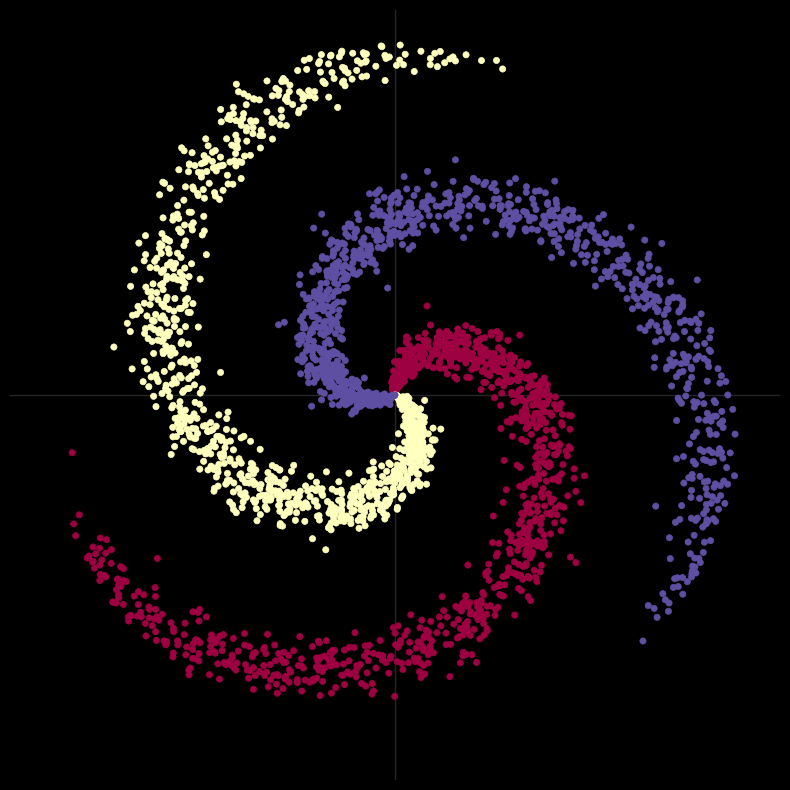

In [25]:
# Creating synthetic data (spiral)

X = jnp.zeros((N * C, D))
y = jnp.zeros(N * C, dtype=jnp.int32)

X_list = []
y_list = []

key, subkey = jax.random.split(key)
for c in range(C):
    t = jnp.linspace(0, 1, N)
    inner_var = jnp.linspace(
        (2 * math.pi / C) * c,
        (2 * math.pi / C) * (2 + c),
        N
    ) + jax.random.normal(jax.random.fold_in(subkey, c), (N,)) * 0.2
    
    X_c = jnp.stack([t * jnp.sin(inner_var), t * jnp.cos(inner_var)], axis=1)
    y_c = jnp.full((N,), c, dtype=jnp.int32)
    
    X_list.append(X_c)
    y_list.append(y_c)

X = jnp.concatenate(X_list, axis=0)
y = jnp.concatenate(y_list, axis=0)

print("Shapes:")
print("X:", X.shape)
print("y:", y.shape)

pl.plot_data(X, y)

## 3. Inisialisasi Parameter Manual
Dalam Pure JAX, parameter model disimpan dalam struktur data sederhana seperti list atau dictionary (disebut **Pytree**).

Kita menggunakan **Glorot/Xavier Initialization** untuk memastikan variansi aktivasi tetap stabil di setiap layer. 
Rumusnya: `limit = sqrt(6 / (fan_in + fan_out))`.

In [26]:
seed = 12345
key = jax.random.PRNGKey(seed)

N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
H = 100  # num_hidden_units

# Manual Initialization Function (Pure JAX)
def init_params(key, layers, input_dim):
    params = []
    keys = jax.random.split(key, len(layers))
    
    curr_dim = input_dim
    for i, (next_dim, k) in enumerate(zip(layers, keys)):
        w_key, b_key = jax.random.split(k)
        # Glorot/Xavier Initialization
        limit = jnp.sqrt(6 / (curr_dim + next_dim))
        w = jax.random.uniform(w_key, (curr_dim, next_dim), minval=-limit, maxval=limit)
        b = jnp.zeros((next_dim,))
        params.append({'w': w, 'b': b})
        curr_dim = next_dim
    return params

## 4. Forward Pass
Model didefinisikan sebagai fungsi murni (`pure function`) yang menerima `params` dan `x`. 
* **ReLU**: Digunakan sebagai fungsi aktivasi di hidden layer untuk memperkenalkan non-linearitas.
* **Logits**: Output terakhir berupa nilai mentah (sebelum softmax) yang merepresentasikan skor untuk setiap kelas.

In [28]:
key, init_key = jax.random.split(key)
params = init_params(init_key, [H, C], D)

# Forward pass
def mlp_fn(params, x):
    for layer in params[:-1]: # Hidden layers with ReLU
        x = jax.nn.relu(jnp.dot(x, layer['w']) + layer['b'])
    return jnp.dot(x, params[-1]['w']) + params[-1]['b']

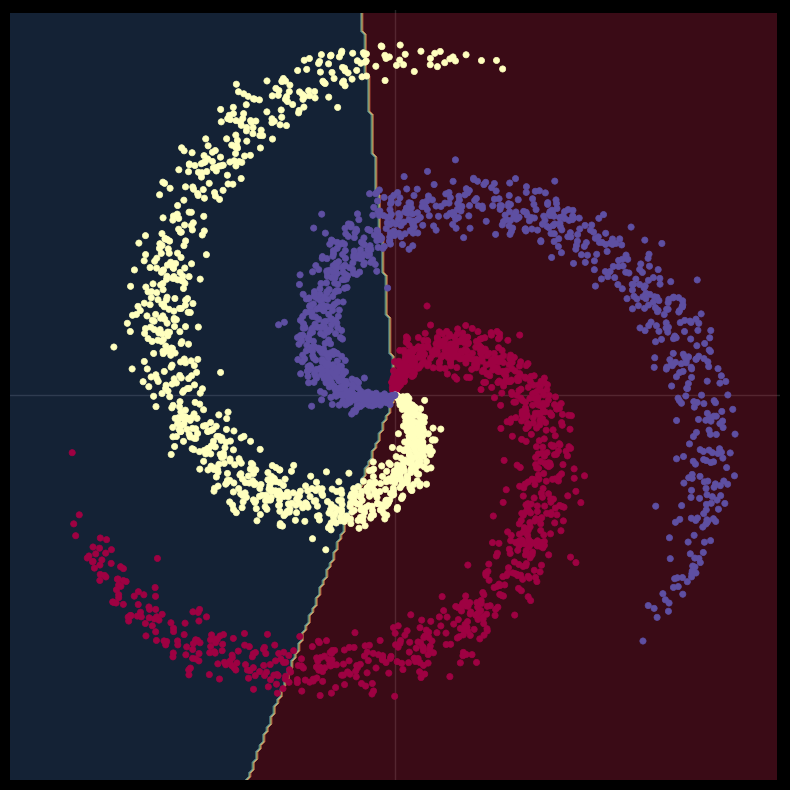

In [29]:
# plot model (before training)
pl.plot_model(X, y, lambda x: mlp_fn(params, x))

## 5. Fungsi Loss & Akurasi
Untuk klasifikasi multi-kelas, kita menggunakan **Sparse Categorical Cross Entropy**.
* `jax.nn.log_softmax`: Digunakan untuk menghitung log-probabilitas secara stabil (menghindari overflow/underflow).
* `loss_fn`: Menghitung seberapa jauh prediksi model dari label asli.

In [30]:
# Define loss and other helper functions
def xent_loss(logits, targets):
    log_probs = jax.nn.log_softmax(logits)
    loss = -jnp.mean(log_probs[jnp.arange(targets.shape[0]), targets])
    return loss

def loss_fn(params, x, y):
    logit_hat = mlp_fn(params, x)
    return xent_loss(logit_hat, y)

def accuracy_fn(params, x, y):
    logit_hat = mlp_fn(params, x)
    return jnp.mean(jnp.argmax(logit_hat, -1) == y)

In [31]:
# Test the xent_loss function
# Forward pass
logit_hat = mlp_fn(params, X)

# Compute loss
loss = xent_loss(logit_hat, y)
print(f"Loss: {loss}") 

Loss: 1.1049972772598267


## 6. Pelatihan dengan Stochastic Gradient Descent dengan mode JIT
Ini adalah inti dari optimasi di JAX:
1. **`jax.value_and_grad`**: Menghitung nilai loss sekaligus gradien terhadap seluruh parameter dalam Pytree.
2. **`@jax.jit`**: Melakukan optimasi kompilasi ke XLA (XLA = Accelerated Linear Algebra) untuk eksekusi yang sangat cepat di GPU/TPU/CPU.
3. **`jax.tree.map`**: Mengaplikasikan aturan update SGD (`p - lr * g`) ke setiap elemen di dalam struktur parameter secara otomatis.

### Process pelatihan

Iteration    0, Loss: 1.1050, Accuracy: 0.4243
Iteration  100, Loss: 0.8206, Accuracy: 0.5320
Iteration  200, Loss: 0.7355, Accuracy: 0.5393
Iteration  300, Loss: 0.7025, Accuracy: 0.5517
Iteration  400, Loss: 0.6761, Accuracy: 0.5693
Iteration  500, Loss: 0.6481, Accuracy: 0.5880
Iteration  600, Loss: 0.6166, Accuracy: 0.6187
Iteration  700, Loss: 0.5819, Accuracy: 0.6537
Iteration  800, Loss: 0.5450, Accuracy: 0.6900
Iteration  900, Loss: 0.5081, Accuracy: 0.7210
Iteration 1000, Loss: 0.4728, Accuracy: 0.7500
Iteration 1100, Loss: 0.4405, Accuracy: 0.7750
Iteration 1200, Loss: 0.4119, Accuracy: 0.7897
Iteration 1300, Loss: 0.3868, Accuracy: 0.8047
Iteration 1400, Loss: 0.3650, Accuracy: 0.8187
Iteration 1500, Loss: 0.3460, Accuracy: 0.8293
Iteration 1600, Loss: 0.3293, Accuracy: 0.8340
Iteration 1700, Loss: 0.3147, Accuracy: 0.8410
Iteration 1800, Loss: 0.3017, Accuracy: 0.8480
Iteration 1900, Loss: 0.2900, Accuracy: 0.8550


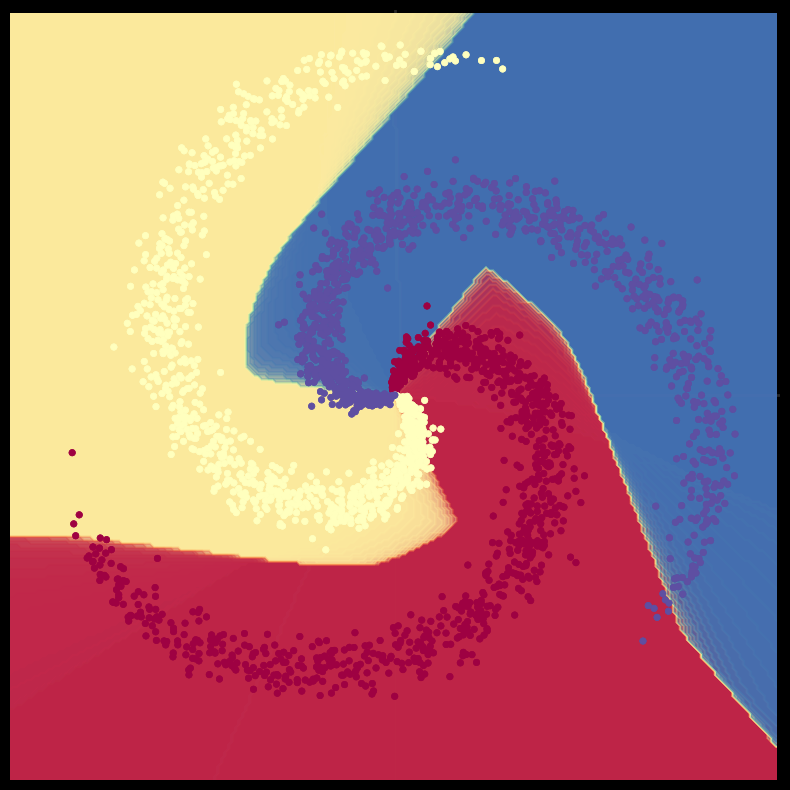

In [32]:
learning_rate = 1e-1
epochs = 2000

@jax.jit
def update(params, x, y):
    loss, grads = jax.value_and_grad(loss_fn)(params, x, y)
    # Manual SGD Update
    new_params = jax.tree.map(lambda p, g: p - learning_rate * g, params, grads)
    return new_params, loss

for i in range(epochs):
    params, loss = update(params, X, y)
    
    if i % 100 == 0:
        acc = accuracy_fn(params, X, y)
        print(f'Iteration {i:4d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')
        
        # Wrap forward for visualization: plot_model expects a function f(x)
        pl.plot_model(X, y, lambda x: mlp_fn(params, x))
        

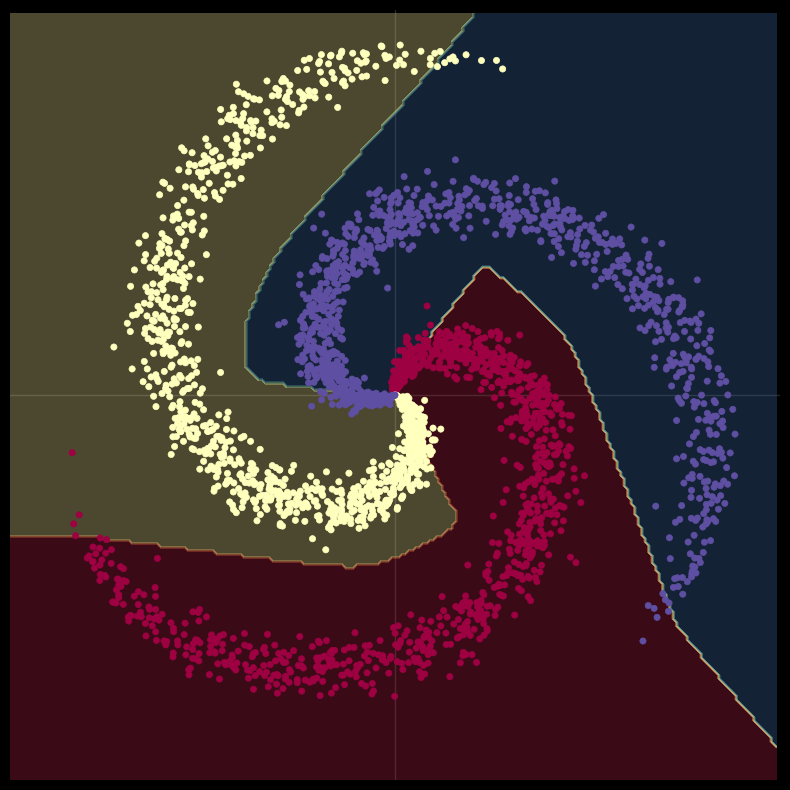

In [33]:
# Final model visualization
pl.plot_model(X, y, lambda x: mlp_fn(params, x))